In [198]:
#Import Libraries
import numpy as np
import matplotlib
from math import *
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [199]:
#Parameter configuration
nx = 500
nz = nx
dx = 1
dz = dx
c0 = 580
isrcx = 250
isrcz = isrcx
irx = 330
irz = 330
f0 = 100
t0 = 4/f0
op = 3
dt = 0.001
nt = 501

print('Source frequency =',f0,'Hz')

#Pressure initialization
p = np.zeros((nz,nx))
pnew = np.zeros((nz,nx))
pold = np.zeros((nz,nx))
d2px = np.zeros((nz,nx))
d2pz = np.zeros((nz,nx))

#Velocity initialization
c = np.zeros((nz,nx))
c= c + c0

#x initialization
x = np.linspace(0,(nx-1)*dx,nx)
z = np.linspace(0,(nz-1)*dz,nz)

#Initialization of empty seismograph
seis = np.zeros(nt)

#Stability criteria 
eps = c0*dt/dx
print('Epsillon =',eps)

Source frequency = 100 Hz
Epsillon = 0.58


In [200]:
#Source defiinition
src=np.zeros(nt+1)
time=np.linspace(0,nt*dt,nt)
#src=-2 * (time-t0) * f0**2 * np.exp(-f0**2 * (time-t0)**2)
src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(-1.0 * (f0 ** 2) * (time - t0) ** 2))


<IPython.core.display.Javascript object>


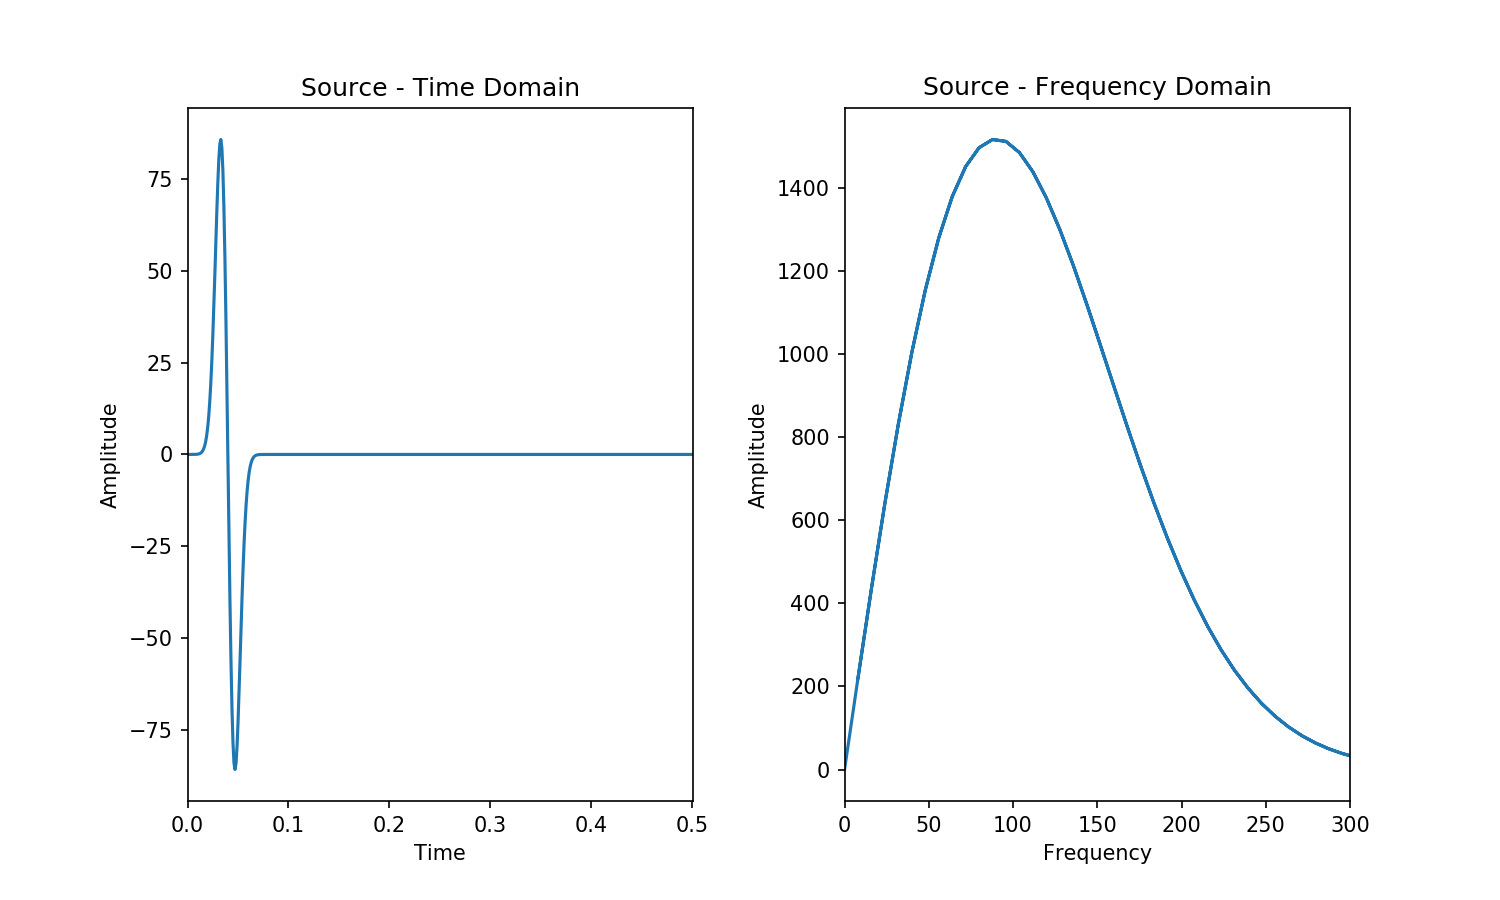

In [201]:
#Plotting the source time function 
plt.ion()
fig1=plt.figure(figsize=(10,6))
grid1=gridspec.GridSpec(1,2,width_ratios=[1,1],wspace=0.3,hspace=0.3)
ax1=plt.subplot(grid1[0])
ax2=plt.subplot(grid1[1])
ax1.plot(time,src)
ax1.set_xlim(0,nt*dt)
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.set_title('Source - Time Domain')
srcfft=np.fft.fft(src)
freq=np.fft.fftfreq(srcfft.size,d=dt/4)
ax2.set_xlim(0,300)
ax2.plot(np.abs(freq),np.abs(srcfft))
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Amplitude')
ax2.set_title('Source - Frequency Domain')
plt.show()

<IPython.core.display.Javascript object>


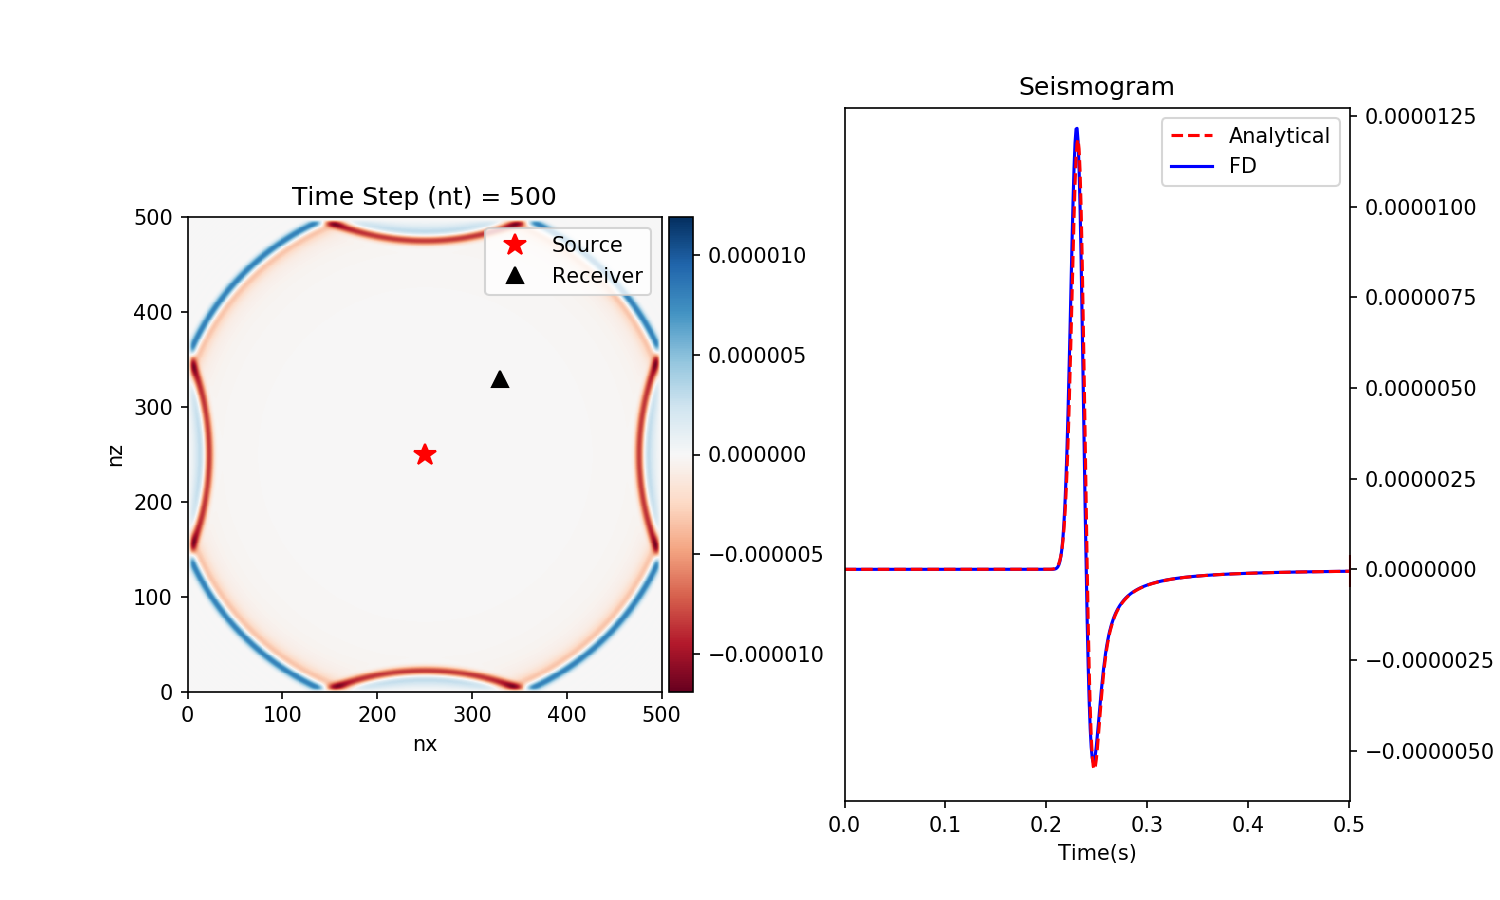

In [202]:
#Snapshot and Seismogram

#Analytical Solution
G = np.zeros(nt+1)
r = np.sqrt((x[isrcx]-x[irx])**2 + (x[isrcz]-x[irz])**2)

for it in range(nt):
    if(time[it]-r/c0 >= 0):
        G[it] = 1./(2 * np.pi * c0**2)*(1./np.sqrt(time[it]**2 - r**2/c0**2))
Gc=np.convolve(G,src*dt)    
Gc=Gc[0:nt]
lim=Gc.max()

fig2 = plt.figure(figsize=(10,6))
grid2 = gridspec.GridSpec(1,2,width_ratios=[1,1],wspace=0.3,hspace=0.3)

#Plot 2D wave propagation
ax3=plt.subplot(grid2[0])
leg1,=ax3.plot(isrcx,isrcz,'r*',markersize=11)
leg2,=ax3.plot(irx,irz,'k^',markersize=8)
im3=ax3.imshow(p, vmin=-lim, vmax=+lim, interpolation="nearest", cmap=plt.cm.RdBu)
div=make_axes_locatable(ax3)
cax=div.append_axes("right", size="5%", pad=0.05) # size & position of colorbar
fig2.colorbar(im3, cax=cax) # plot colorbar
ax3.set_title('Time Step (nt) = 0')
ax3.set_xlim(0,nx)
ax3.set_ylim(0,nz)
ax3.set_xlabel('nx')
ax3.set_ylabel('nz')
ax3.legend((leg1,leg2),('Source','Receiver'),loc='upper right')

#Plot seismogram
ax4=plt.subplot(grid2[1])
up41,= ax4.plot(time,seis,'b-')
up42,= ax4.plot([0],[0],'r|',markersize=15)
ax4.set_xlim(0,nt*dt)
#ax4.set_ylim(0,1.1*Gcmax)
ax4.set_title('Seismogram')
ax4.set_xlabel('Time(s)')
ax4.set_ylabel('Amplitude')
leg3,=ax4.plot(0,0,'r--')
leg4,=ax4.plot(0,0,'b-')
ax4.legend((leg3,leg4),('Analytical','FD'),loc='upper right')
plt.plot(time,Gc,'r--')    
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

plt.show()



In [203]:
#Numerical Solution
idisp=5
degree=5
for it in range(nt):
    if degree==3:
        for i in range(1,nx-1):
            d2px[:,i]=(p[:,i-1] - 2*p[:,i] + p[:,i+1])/(dx**2)
        for i in range(1,nz-1):
            d2pz[i,:]=(p[i-1,:] - 2*p[i,:] + p[i+1,:])/(dz**2)
    if degree==5:
        for i in range(2,nx-2):
            d2px[:,i]=((-1/12.0) * p[:,i-2] + (4/3.0) * p[:,i-1] - (5/2.0) * p[:,i] + (4/3.0) * p[:,i+1] - (1/12.0) * p[:,i+2])/(dx**2)
        for i in range(2,nz-2):
            d2pz[i,:]=((-1/12.0) * p[i-2,:] + (4/3.0) * p[i-1,:] - (5/2.0) * p[i,:] + (4/3.0) * p[i+1,:] - (1/12.0) * p[i+2,:])/(dz**2)
    pnew = 2*p - pold + (c**2 * dt**2)*(d2px + d2pz)
    pnew[isrcz,isrcx] = pnew[isrcz,isrcx] + src[it] * dt**2 / (dx*dz)
    pold=p
    p=pnew
    seis[it] = p[irz,irx]
    if(it%idisp==0):
        ax3.set_title('Time Step (nt) = %d' %(it))
        ax3.imshow(p,vmin=-lim, vmax=+lim, interpolation="nearest", cmap=plt.cm.RdBu)
        up41.set_ydata(seis)
        up42.set_data(time[it],seis[it])
        plt.gcf().canvas.draw()
    
    